# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification



In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.


### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](landmark_images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="landmark_images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn 
import torch.optim as optim

# Define training and test data directories
data_dir = 'landmark_images1/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')


# Create data transforms
train_transforms = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation((0, 180)),
    transforms.RandomResizedCrop((224, 224)),
    transforms.ToTensor()
    ])
    
test_transforms = transforms.Compose([ 
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
    ])

# Number of subprocesses to use for data loading
num_workers = 8
# How many samples per batch to load
batch_size = 20
#Percentage of training set to use as validation
valid_size = 0.2

# Load and transform data using ImageFolder
train_data = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transforms)

# Obtain training indices for trainig and validation
num_train = len(train_data)

train_size = int(0.8 * num_train)
val_size  = num_train - train_size
data_train, data_val = torch.utils.data.random_split(train_data, [train_size, val_size])

# Apply test transforms to validation set
data_val.transforms = test_transforms

train_loader = torch.utils.data.DataLoader(data_train,  batch_size=batch_size, \
     num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, \
     num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, \
    num_workers=num_workers)

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

# Print some data statistics
print('Number of training images: ', len(train_data))
print('Number of test images: ', len(test_data))

Number of training images:  4996
Number of test images:  1250


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**:     
I resized each image to $224\times224$, randomly cropped portion of the image and resized it back to $224\times224$. The choice of $224\times224$ size is motivated by the need to lower memory use, increase computational speed and the fact that this size works for standard 3 channel images, such as `vgg16`.    
I did not apply any data augmentation. Since these are landmark images, photos are unlikely to be taken flipped, rotated, and the random cropping would account for translation. Moreover, a little bit of experimentation reveals the model underperforms when random rotation and horizontal flips are applied to the images.       
I did not apply normalization, a print of some images show the pixel values may have been normalized already.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

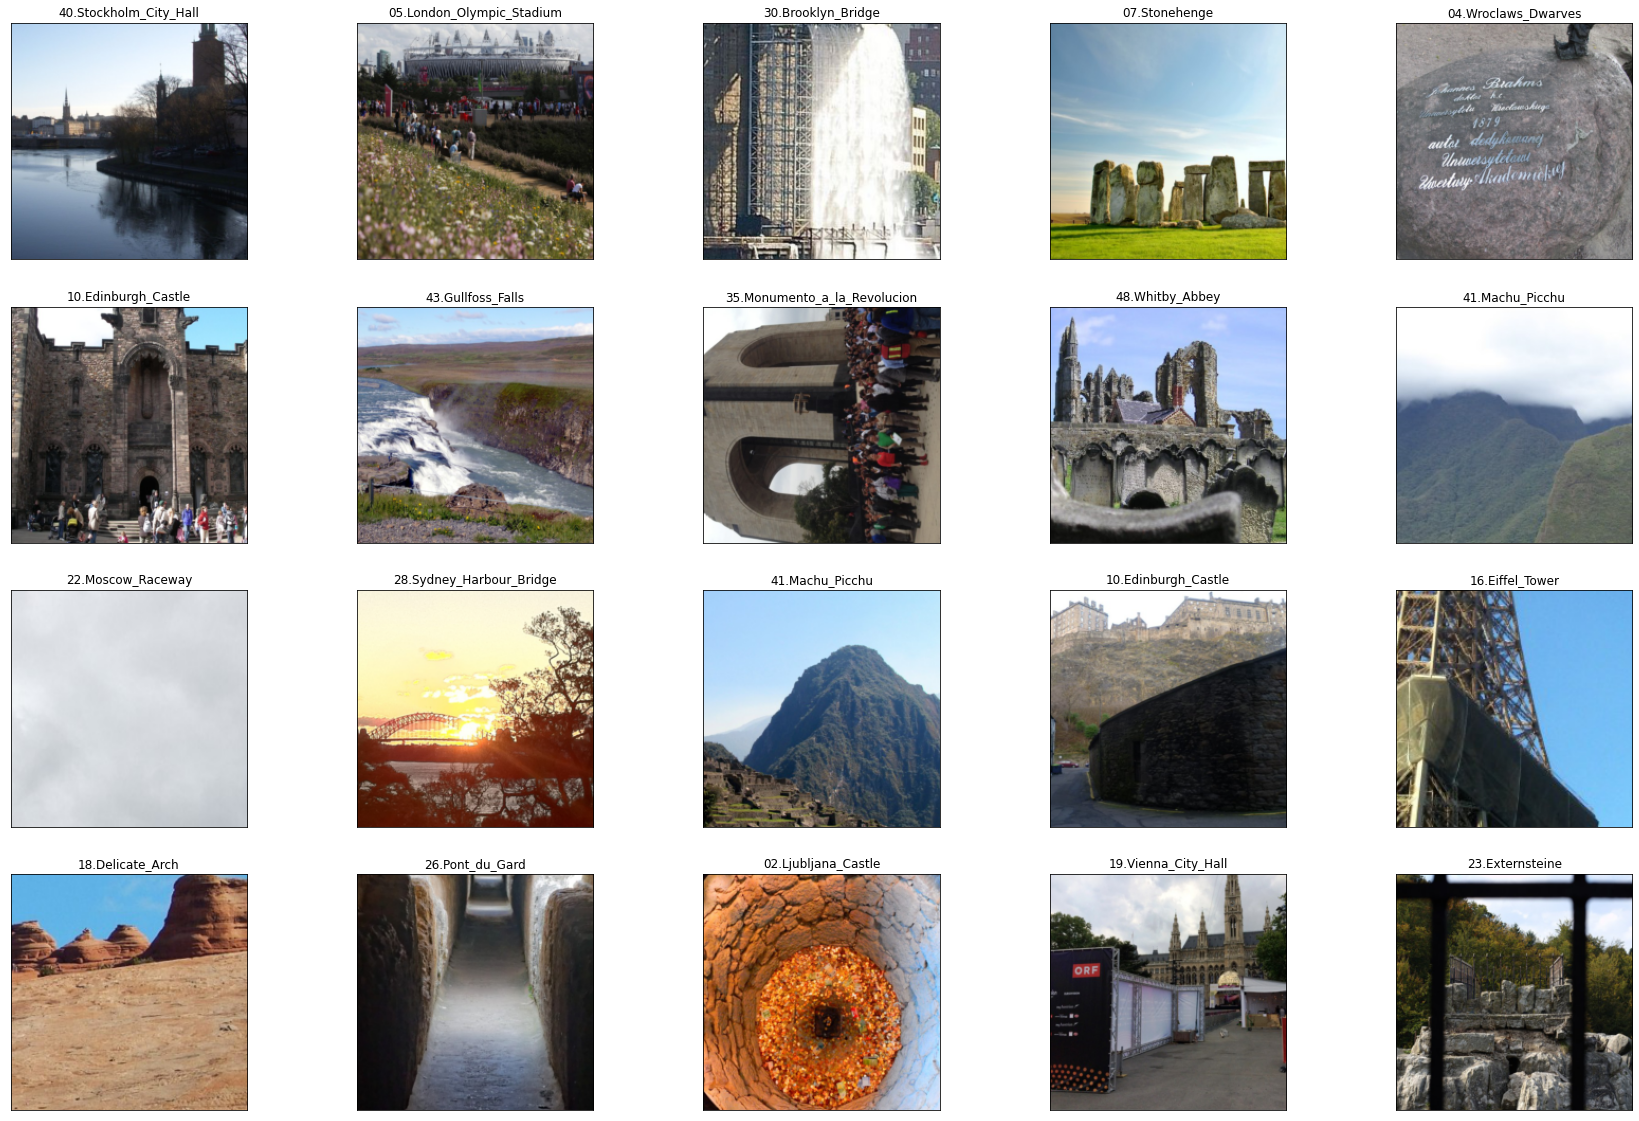

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

# Obtain a batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()            # Convert images to numpy for display

# Plot images in the batch, along with their labels
fig = plt.figure(figsize=(30, 20))

for idx in range(batch_size):
    ax = fig.add_subplot(4, batch_size//4, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1,2,0)))
    ax.set_title(train_data.classes[labels[idx]])
plt.show()

### Initialize use_cuda variable

In [3]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [4]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    return optim.SGD(model.parameters(), lr=0.02)
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        # Convolutional layers
        self.conv1 = nn.Conv2d(3,64, 3, padding=1)
        self.conv2 = nn.Conv2d(64,64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 16, 3, padding=1)
        # Max pool layer
        self.pool = nn.MaxPool2d(2,2)
        # Linear layers
        self.fc1 = nn.Linear(16*28*28, 50)
        # Define proportion of neurons to dropout
        self.dropout = nn.Dropout(0.2)

        
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
model_scratch

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=50, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__      
I used only 3 convolutional layers and 1 linear fully connected layer with `ReLU` activation applied to each convolutional layer, followed by a $2\times2$ max pooling. I imagined that $64$ filters should be able to learn distributions of $50$ classes, so each convolutional layer has an out channel of $64$, except the last one, since I do not want the linear fully connected layer to be over parametrized. I desire to create a sufficient but simple nonlinear model. Given more resources and time, I would experiment with deeper layers and more filters, conditioned on hyperparameter optimized values. 

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [6]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # Implement schedular
    schedular = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

            # Clear gradients of all optimized variables
            optimizer.zero_grad()
            # Forward pass
            output = model(data)
            # Calculate loss          
            loss =  criterion(output, target)
            # Backward pass
            loss.backward()
            # Optimize and update parameter
            optimizer.step()
            # Update the average training loss
            train_loss += train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            
        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            # Forward pass
            output = model(data)
            # Calculate loss
            loss = criterion(output, target)
            # Update average validation loss
            valid_loss += valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))           

        # print training/validation statistics 
        if epoch % 10 == 0:
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                epoch, 
                train_loss,
                valid_loss
                ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored 
        ##        in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreases ({:.4f} --> {:.4f}). Saving model \
                ...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

        # Decay learning rate
        schedular.step()
    
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [7]:
def custom_weight_init(m):
    # TODO: implement a weight initialization strategy
    '''
    Takes in a module `m` and initializes all linear layers with weight values 
    from a normal distribution
    '''

    classname = m.__class__.__name__
    # For every lineae layer in a model
    # m.weight.data is drown from a normal distribution
    # m.bias.data is 0
    if classname.find('Linear') != -1:
        # Get the number of inputs
        n = m.in_features
        y = (1.0 / np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)

model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Validation loss decreases (inf --> 543418687646692.6875). Saving model                 ...
Validation loss decreases (543418687646692.6875 --> 528205163818348.1250). Saving model                 ...
Validation loss decreases (528205163818348.1250 --> 511579394009460.5000). Saving model                 ...
Validation loss decreases (511579394009460.5000 --> 499659841394777.9375). Saving model                 ...
Validation loss decreases (499659841394777.9375 --> 481694740813277.3750). Saving model                 ...
Validation loss decreases (481694740813277.3750 --> 480337505921573.6875). Saving model                 ...
Epoch: 10 	Training Loss: 371337956637540935463546647684862553195259387202185600172032.000000 	Validation Loss: 488336770588530.062500
Validation loss decreases (480337505921573.6875 --> 463756878718332.2500). Saving model                 ...
Validation loss decreases (463756878718332.2500 --> 453889131953830.0625). Saving model                 ...
Validation loss de

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [8]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 100

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')


Validation loss decreases (inf --> 541438112139821.1250). Saving model                 ...
Validation loss decreases (541438112139821.1250 --> 515747933682178.9375). Saving model                 ...
Validation loss decreases (515747933682178.9375 --> 503322991952733.7500). Saving model                 ...
Validation loss decreases (503322991952733.7500 --> 485874424014206.8750). Saving model                 ...
Validation loss decreases (485874424014206.8750 --> 479422003847294.4375). Saving model                 ...
Validation loss decreases (479422003847294.4375 --> 452977196967997.0000). Saving model                 ...
Epoch: 10 	Training Loss: 343195702473517217220713632121031252886354826618885686427648.000000 	Validation Loss: 473691451997559.875000
Validation loss decreases (452977196967997.0000 --> 429970146137359.3125). Saving model                 ...
Validation loss decreases (429970146137359.3125 --> 423361199382075.1250). Saving model                 ...
Epoch: 20 	Trainin

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [9]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.620961


Test Accuracy: 34% (437/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [10]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn 
import torch.optim as optim

# Define training and test data directories
data_dir = 'landmark_images1/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')


# Create train data transforms
train_transforms = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation((0, 180)),
    transforms.RandomResizedCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
 # Test and validation data transforms 
test_transforms = transforms.Compose([ 
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Number of subprocesses to use for data loading
num_workers = 8
# How many samples per batch to load
batch_size = 20
#Percentage of training set to use as validation
valid_size = 0.2

# Load and transform data using ImageFolder
train_data = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transforms)

# Split train data into trainig and validation
num_train = len(train_data)
train_size = int(0.8 * num_train)
val_size  = num_train - train_size
data_train, data_val = torch.utils.data.random_split(train_data, [train_size, val_size])

# Apply test transforms to validation set
data_val.transforms = test_transforms


train_loader = torch.utils.data.DataLoader(data_train,  batch_size=batch_size, \
     num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, \
     num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, \
    num_workers=num_workers)

loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

# Print some data statistics
print('Number of training images: ', len(train_data))
print('Number of test images: ', len(test_data))

Number of training images:  4996
Number of test images:  1250


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [11]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    return optim.SGD(model.parameters(), lr=0.02)
    
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [12]:
## TODO: Specify model architecture

from torchvision import models
# Load the pretrained model from pytorch
model_transfer = models.vgg16(pretrained=True)

# Visualize the pretrained model architecture
model_transfer

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False

# Replace last fully connected layer to fit into landmarks classes
# new layers automatically have requires_grad = True
no_in = model_transfer.classifier[6].in_features
no_out = len(train_data.classes)
model_transfer.classifier[6] = nn.Linear(no_in, no_out)

In [14]:

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__      
The model uses the `vgg16`, one of the most powerful pretrained models, as a feature detector. `vgg16` has $16$ trained convolutional layers with a fixed $3\times3$ filter size; the number of filters progressively increasing from $16$ to $512$. Each convolutional layer is passed through a `ReLU` activation with a total of $5$ max pooling of size $2\times2$ filters intermittently applied. The result is then passed to $3$ linear fully connected layers, with `ReLU` activation and dropout applied.    
I only changed the last linear fully connected classifier layer to output the $50$ classes of the landmark images, as opposed to the $1000$ classes the `vgg16` model was trained on. All other parameters of the prtrained model are frozen. I also used normalized the images to a mean and standard deviation of [0.485, 0.456, 0.406], [0.229, 0.224, 0.225] respectively corresponding to the three channels since this is the normalization applied on the `ImageNet` dataset, on which the `vgg16` model was trained on.    
Beyond the understanding the `vgg16` model was trained on 3 channel images, has simple architecture and preprocessing that the landmark images can easily be adapted to, it is well known that models that are well trained and optimized on large datasets are great as feature detectors. Given more resources and time,  I would experiment with `vgg19`, Google `Inception` and other great models that have proven reputation for detecting image characteristics.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [15]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
num_epochs = 100
model_transfer = train(num_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                      criterion_transfer, use_cuda, 'model_transfer.pt')


#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Validation loss decreases (inf --> 199649130778981.6250). Saving model                 ...
Validation loss decreases (199649130778981.6250 --> 175237969101796.7188). Saving model                 ...
Validation loss decreases (175237969101796.7188 --> 149770220121832.5000). Saving model                 ...
Validation loss decreases (149770220121832.5000 --> 139512137607065.7344). Saving model                 ...
Validation loss decreases (139512137607065.7344 --> 136072611756044.7031). Saving model                 ...
Epoch: 10 	Training Loss: 71177882453929878821847456957610121989663221024829265149952.000000 	Validation Loss: 121993980259031.406250
Validation loss decreases (136072611756044.7031 --> 121993980259031.4062). Saving model                 ...
Validation loss decreases (121993980259031.4062 --> 102970316209839.3438). Saving model                 ...
Epoch: 20 	Training Loss: 26637092474775760338604651669705002432192085000415120195584.000000 	Validation Loss: 147771807008907.

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [16]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.851526


Test Accuracy: 81% (1013/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [17]:
import cv2
from PIL import Image
import re

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    # Load the image
    image = Image.open(img_path)
    # Create data transforms
    data_transforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
    # Transform data
    img_trans = data_transforms(image).unsqueeze(0)
    # Set model to evaluation mode
    model_transfer.eval()
    # Pass into the model
    output =  model_transfer(img_trans.cuda())
    # Get the top k probabilities
    top_k, top_cl = torch.topk(output, k)
    # Convert the topk to numpy array
    ml_classes = top_cl.cpu().numpy()
    # Get the topk class labels
    predictions = [train_data.classes[i] for i in ml_classes[0]]
    # Strip numbers in the labels
    result = [re.sub(r'[0-9, .]', '', elem) for elem in predictions]
    return result

# test on a sample image
predict_landmarks('landmark_images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Golden_Gate_Bridge',
 'Dead_Sea',
 'Sydney_Harbour_Bridge',
 'Forth_Bridge',
 'Temple_of_Heaven']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

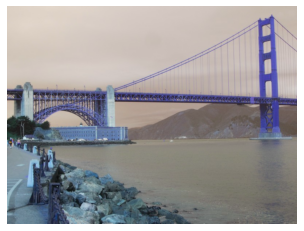

Is this picture of the Golden_Gate_Bridge, Dead_Sea, or Sydney_Harbour_Bridge?


In [18]:
def suggest_locations(img_path):
    # get landmark predictions
    no_locs = 3
    predicted_landmarks = predict_landmarks(img_path, no_locs)
    
    ## TODO: display image and display landmark predictions
    # Read image
    image = cv2.imread(img_path)
    # Plot image
    plt.imshow(image)
    # Turn off axes
    plt.axis('off')
    plt.show()
    # Format model results for printing
    model_pred = "Is this picture of the " + "".join(["{}, " for i in range(no_locs-1)]) + "or {}?"
    return model_pred.format(*[lmk for lmk in predicted_landmarks])

# test on a sample image
print(suggest_locations('landmark_images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg'))

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)    
*  I used random landmark images from the internet and based on the accuracy, the model is doing a great job suggesting closely related landmarks. A possible point of improvement, in building a great `suggest_locations` app is to include more classes of images in the training and testing datasets.  
*  Training the model on more classifier layers might lead to improvement.
*   Fine tuning the `vgg16` on the landmark images is also worthy of trial.
*    Hyperparameter optimzation is definitely a must try.
*    Trying other pretrained models such as Google Inception would be a worthy adventure.


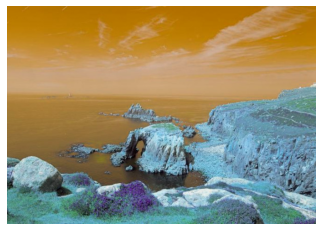

Is this picture of the Dead_Sea, Grand_Canyon, or Badlands_National_Park?


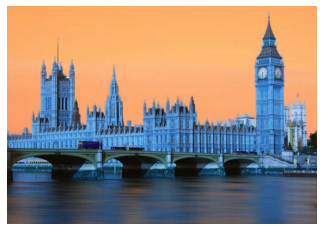

Is this picture of the Vienna_City_Hall, Petronas_Towers, or Gateway_of_India?


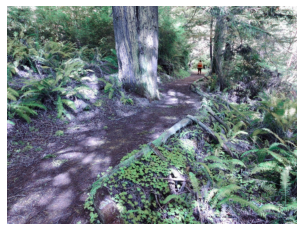

Is this picture of the Taj_Mahal, Wroclaws_Dwarves, or Externsteine?


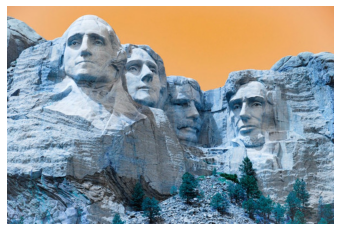

Is this picture of the Mount_Rushmore_National_Memorial, Badlands_National_Park, or Dead_Sea?


In [19]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

# for i in range(4):
    # print(suggest_locations("landmark_images/poster_{}.jpg".format(i+1)))
print(suggest_locations('landmark_images/land-end-cornwall.jpg'))
print(suggest_locations('landmark_images/palace-of-westminster.jpg'))
print(suggest_locations('landmark_images/redwood-national-park.jpg'))
print(suggest_locations('landmark_images/mount-rushmore.jpg'))

## Appreciation
Many thanks to my first reviewer whose recommendations greatly improved the performance of the updated model.